In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

NAME = 'ladle_furnace_inference'

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. 


## **A - Building scenarios with different detector configurations**

We'll begin by defining the **number of simulations** we want to produce, their individual **data taking time**, and the considered **flux of muons**.

In [2]:
Simulations = 100 # number of simulations
Time = 5 # muography measurement time of a single simulation [min]
Flux = 6845 # considered flux of muons [muons/(min*m^2)]

Then, we will continue defining 4 scenarios with different detector configurations. Each scenario corresponds to a **volume**, consisting of the configured **detectors** and a **passive volume**. 

In [3]:
from tomopt.volume import Volume
from tomopt.benchmarks.ladle_furnace import get_detector

In [4]:
# Detection panel span [m]
PanelSpan = 0.7
# PanelSpan = 0.9

# muon hit detection resolution [m]
Resolution = 0.00001 # 0,01 mm (really high resolution)

PanelZ = [1.80, 1.65, 1.50, 0.30, 0.15, 0.00] # Big gap

volume_BigGapHighRes = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e5, panelZpositions=PanelZ), budget=6)
volume_BigGapHighRes

# muon hit detection resolution [m]
Resolution = 0.001 # 1 mm (common muography detector)

volume_BigGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_BigGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.25, 0.20] # Small gap

volume_SmallGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_SmallGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.15, 0.00] # Not centred

volume_NotCentred = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_NotCentred


Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We can visualise the layout of this in 3D. Note the closeness of the panels, and their offset from the passive volume. We do not expect this detector to perform well, but we can optimise it to a better configuration.

<IPython.core.display.Javascript object>


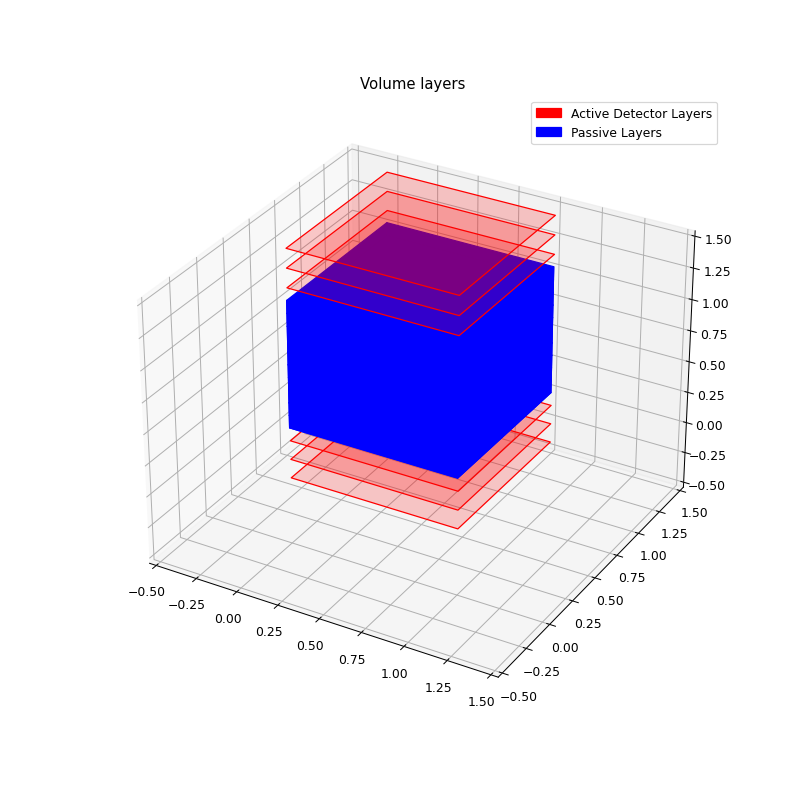

In [5]:
%matplotlib notebook
volume_BigGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

<IPython.core.display.Javascript object>


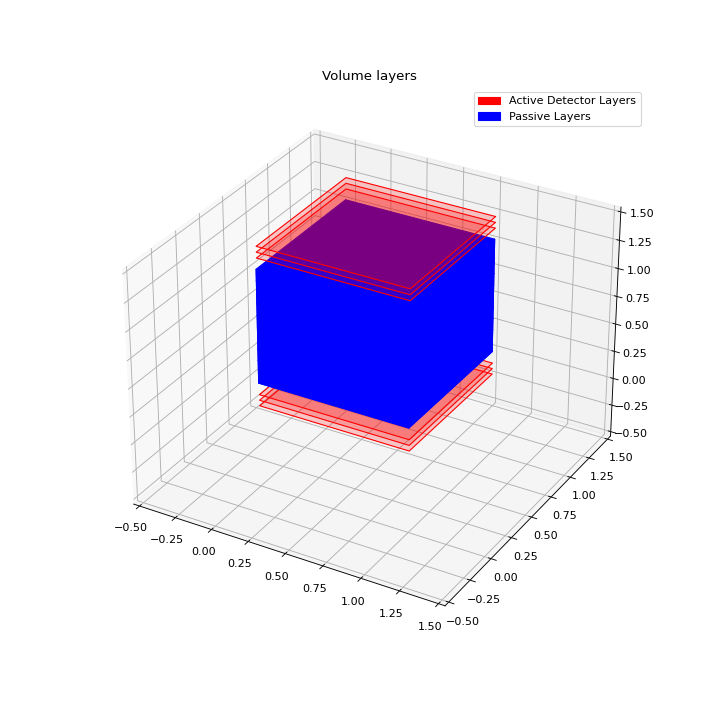

In [6]:
%matplotlib notebook
volume_SmallGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

<IPython.core.display.Javascript object>


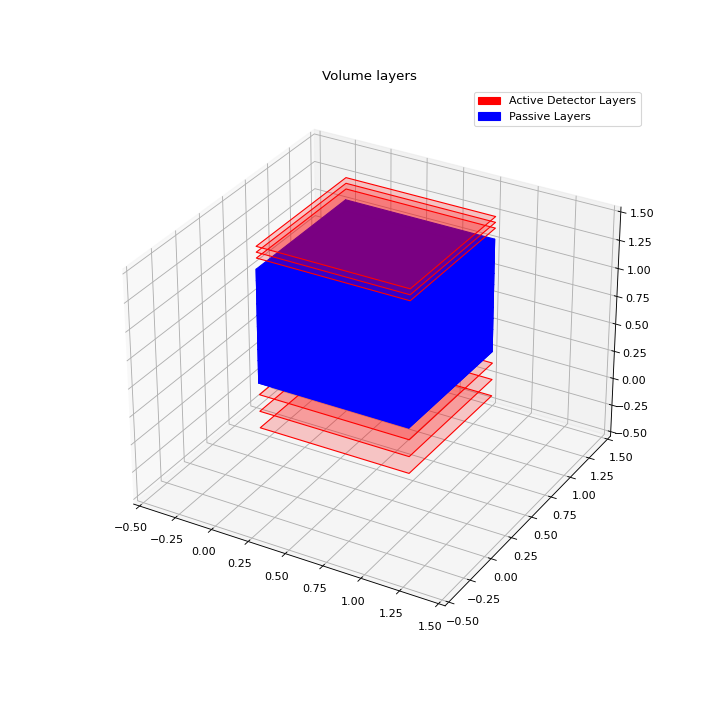

In [7]:
%matplotlib notebook
volume_NotCentred.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

In [8]:
%matplotlib inline

## **B - Passive volume generation**

Now we'll need to define how to **generate** example **passive volumes**. The furnace ladle is nade of several elements:

 - **Ladle**: a $1\times1\times1 \:[\text{m}^3]$ bucket made of solid steel.

 - **Liquid steel**: The ladle is filled with a **random amount** of liquid steel.

 - **Slag**: Above the liquid steel is a **layer** of **slag**, with a lower density that liquid steel.

 - **Air**: The rest of the ladle is filled with air.


`LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [ ]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [9]:
passive_gen = LadleFurnacePassiveGenerator(volume_BigGapHighRes)
passive_gen = LadleFurnacePassiveGenerator(volume_BigGap)
passive_gen = LadleFurnacePassiveGenerator(volume_SmallGap)
passive_gen = LadleFurnacePassiveGenerator(volume_NotCentred)

For a single training epoch, we'll generate 5 volumes at a range of fill-heights. The 10cm of slag will be present for ever volume.

In [11]:
N_PASSIVES_PER_H = 5
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

In [13]:
from tomopt.optimisation import PassiveYielder

In [14]:
trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

Let's visualise one these volume layouts by repurposing one of the visualisers in TomOpt

In [15]:
f,t = trn_passives.passives[20]
volume_BigGapHighRes.load_rad_length(f, t)

In [16]:
from tomopt.plotting import plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [17]:
x02id = {X0['air']:0, X0['slag']:1, X0['hot liquid steel']:2, X0['steel']:3}
x02id

true = volume_BigGapHighRes.get_rad_cube()
class_true = x0targs_to_classtargs(true, x02id)

In [ ]:
import numpy as np

Absolute fill height tensor([1.])


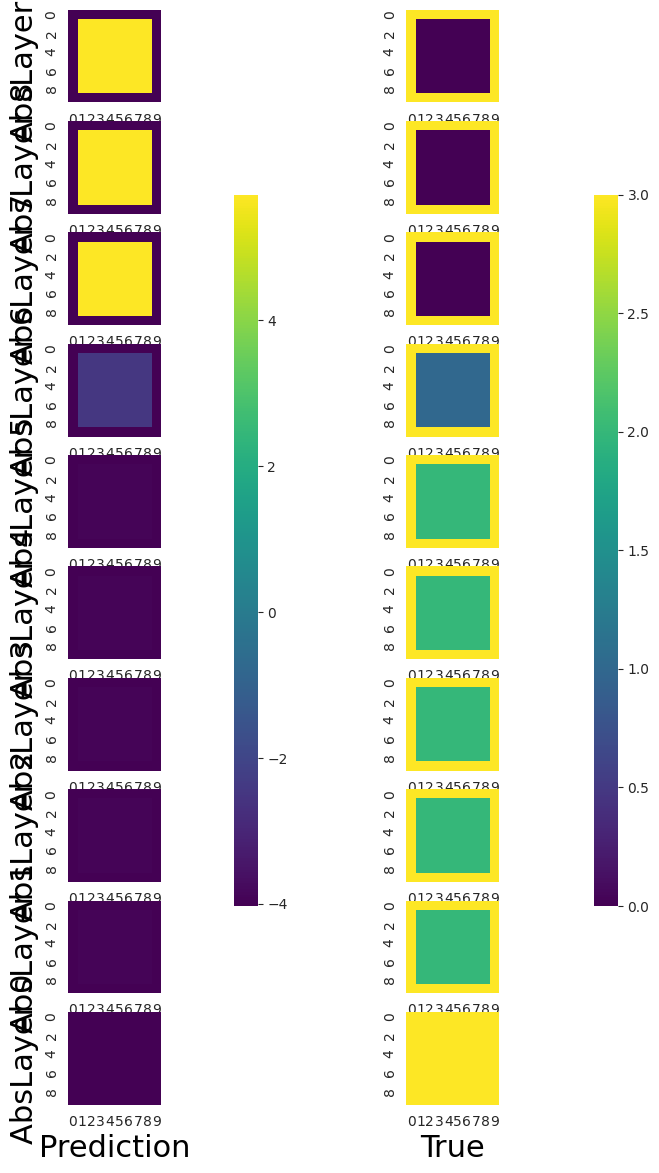

In [22]:
print("Absolute fill height", t)
plot_pred_true_x0(np.log(true), class_true)

Ignoring the predicted and true labels, on the right is the layers of the ladle, coloured by voxel material: 

 - Yellow = **ladle** (steel) 
 - Green = **liquid steel** 
 - Blue = **Slag** 
 - Purple = **Air**

On the left is the same set of layers, but coloured by material log_10 of the X0. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

## **C - Develop inference method**


In [25]:
# Choose volume
volume=volume_BigGapHighRes

In [49]:
from tomopt.inference import ScatterBatch

In [ ]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [52]:
gen = MuonGenerator(x_range=(0.0,1.0), y_range=(0.0,1.0), fixed_mom=5)

In [58]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0]) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0]) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [61]:
from torch import Tensor

In [ ]:
from tomopt.muon import MuonBatch

In [62]:
muons = MuonBatch(gen(100), init_z=1)
volume = Volume(get_layers())
volume(muons)

NameError: name 'PanelDetectorLayer' is not defined

In [ ]:
%%time
sb = ScatterBatch(mu=muons, volume=volume)

In [35]:
from tomopt.optimisation import ArbVolumeWrapper, VolumeMSELoss
from tomopt.benchmarks.ladle_furnace import PocaZLadleFurnaceFillLevelInferrer
from functools import partial

In [42]:
lu, ld = volume.get_detectors()[0], volume.get_detectors()[1]
opts = {'xy_pos_upper':torch.optim.SGD((p.xy for p in lu.panels), lr=3.0),
        'z_pos_upper':torch.optim.SGD((p.z for p in lu.panels), lr=0.01),
        'xy_pos_lower':torch.optim.SGD((p.xy for p in ld.panels), lr=3.0),
        'z_pos_lower':torch.optim.SGD((p.z for p in ld.panels), lr=0.01),
        'budget_weights':torch.optim.SGD((p for p in [volume.budget_weights]), lr=0.01)
       }
wrapper = ArbVolumeWrapper(volume,
                             opts=opts,
                             loss_func=VolumeMSELoss(target_budget=None),
                             partial_volume_inferrer=partial(PocaZLadleFurnaceFillLevelInferrer, smooth=1.0))

In [48]:
#import PanelVolumeWrapper
from tomopt.optimisation.wrapper import PanelVolumeWrapper    

def generate_wrapper(volume:Volume) -> PanelVolumeWrapper:
    
    # import PassiveYielder
    from tomopt.optimisation.data.passives import PassiveYielder
    from functools import partial

    # Ladle furnace loss function
    from tomopt.benchmarks.ladle_furnace import LadleFurnaceIntClassLoss, LadleFurnaceFillLevelInferrer

    # X0 inference
    from tomopt.inference.volume import PanelX0Inferrer
    
    # Create wrapper
    wrapper = PanelVolumeWrapper(volume,
                             mu_generator=MuonGenerator2016(x_range=(-0.5,1.5), y_range=(-0.5,1.5), fixed_mom=None),
                             #mu_generator=MuonGenerator2016(x_range=(-1.0,2.0), y_range=(-1.0,2.0), fixed_mom=None),
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=LadleFurnaceIntClassLoss(use_mse=True, target_budget=None),
                             partial_volume_inferrer=partial(LadleFurnaceFillLevelInferrer, 
                                                             partial_x0_inferrer=PanelX0Inferrer, 
                                                             output_probs=False))
    #set partial_volume_inferrer                                                         
    wrapper.partial_volume_inferer = partial(LadleFurnaceFillLevelInferrer, 
                                             partial_x0_inferer=PanelX0Inferrer, 
                                             output_probs=True)
    
    return wrapper

# import Callbacks
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, MuonResampler
from tomopt.optimisation.callbacks.diagnostic_callbacks import *
#from tomopt.optimisation.callbacks.full_diagnosis_callbacks import *

class VolumeRecord(Callback):

    def __init__(self):
        self.volume_rad_length = None

    def on_volume_begin(self):

        self.volume_rad_length = self.wrapper.volume.get_rad_cube()

NameError: name 'Callback' is not defined

In [45]:
preds = wrapper.predict(test_passives,
                    n_mu_per_volume=n_mu_per_volume,
                    mu_bs=1000,
                    mu_init_z=1.,
                    cbs=[MuonResampler(),hr,sr,sar,vr], # With muon resampler
                    #cbs=[sr,sar,vr, 
                    #     CallbackExposureTime(exposure_time=ExposureTime, n_mu_min_m2=MuonFlux)], # Without muon resampler
                    pred_cb=VolumeTargetPredHandler())

AttributeError: module 'tomopt.optimisation.wrapper' has no attribute 'predict'

In [97]:
# Run muography simulations

# Get POCA (without, and with weights)

# Calculate POCAz mean and model steel level (1st, and 2nd order)

# Invert and get inference formula


## **D - Inference**


### **Optimiser setup**

We'll define separate optimisers for panels above and below the passive volume, and each of their xy, or z positions. Additionally, we'll have a separate optimiser to adjust the budget distribution to the panels.

In [ ]:
# Choose volume
volume=volume_BigGapHighRes

In [78]:
lu, ld = volume.get_detectors()[0], volume.get_detectors()[1]
opts = {'xy_pos_upper':torch.optim.SGD((p.xy for p in lu.panels), lr=3.0),
        'z_pos_upper':torch.optim.SGD((p.z for p in lu.panels), lr=0.01),
        'xy_pos_lower':torch.optim.SGD((p.xy for p in ld.panels), lr=3.0),
        'z_pos_lower':torch.optim.SGD((p.z for p in ld.panels), lr=0.01),
        'budget_weights':torch.optim.SGD((p for p in [volume.budget_weights]), lr=0.01)
       }

Now we'll create a volume wrapper to contain the optimisers, volume, and inference methods. The inference method is described in the paper, and uses the mean of the POCA z-positions to provide a prediction of the fill-height.

In [79]:
from tomopt.optimisation import ArbVolumeWrapper, VolumeMSELoss
from tomopt.benchmarks.ladle_furnace import PocaZLadleFurnaceFillLevelInferrer
from functools import partial

In [80]:
wrapper = ArbVolumeWrapper(volume,
                             opts=opts,
                             loss_func=VolumeMSELoss(target_budget=None),
                             partial_volume_inferrer=partial(PocaZLadleFurnaceFillLevelInferrer, smooth=1.0))

### **Inference**

Let's evaluate the initial performance of our detector. We'll do this on a test dataset of 100 passive volumes at each of our specified heights.

In [81]:
test_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(100//len(HEIGHTS)) for h in HEIGHTS])
len(test_passives)

96

For evaluation of the predictions, we'll want to also have access to the the true fill-height. We'll use the `VolumeTargetPredHandler` to ensure this information isn't lost.

In [82]:
from tomopt.optimisation import VolumeTargetPredHandler, MuonResampler

In [83]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=1000,
                mu_bs=1000,
                pred_cb=VolumeTargetPredHandler(),
                cbs=[MuonResampler()])

The returned predictions consist of pairs of predicted and true fill-heights. Lets plot out the bias and MSE:

In [84]:
preds[:5]

[(array([1.1750503], dtype=float32), array([0.6], dtype=float32)),
 (array([1.1171988], dtype=float32), array([0.7], dtype=float32)),
 (array([1.108084], dtype=float32), array([0.8], dtype=float32)),
 (array([1.1119406], dtype=float32), array([0.9], dtype=float32)),
 (array([1.0966603], dtype=float32), array([1.], dtype=float32))]

In [85]:
import pandas as pd

In [86]:
df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_start['gen_target'] = volume.passive_size*((df_start.gen_target/volume.passive_size)//1)
df_start['bias'] = (df_start.gen_target-df_start.pred)
df_start['mse'] = df_start.bias**2

In [87]:
df_start.mse.mean()

0.08329532

In [88]:
!mkdir {NAME}_plots

mkdir: no se puede crear el directorio «ladle_furnace_inference_plots»: El archivo ya existe


In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from tomopt.plotting import STYLE, TK_COL, TK_SZ, LBL_COL, LBL_SZ, W_MID, H_MID

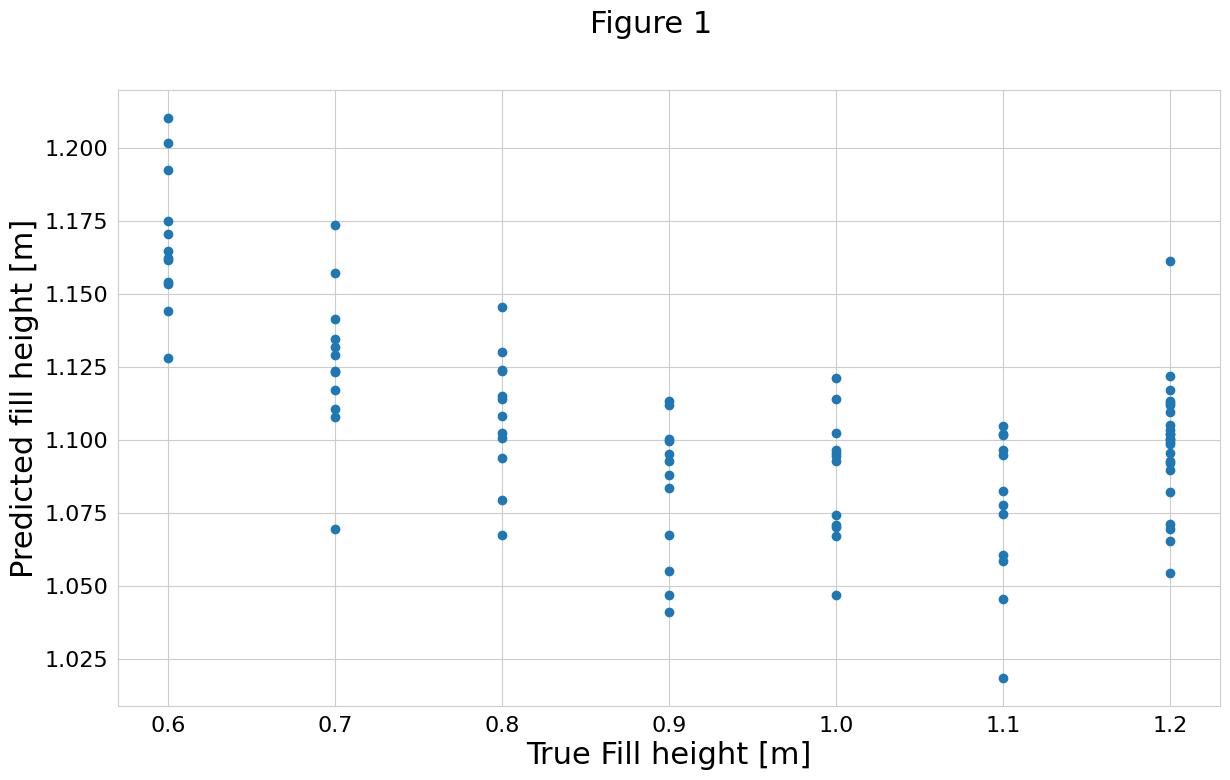

In [90]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 1", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.pred)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('Predicted fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)

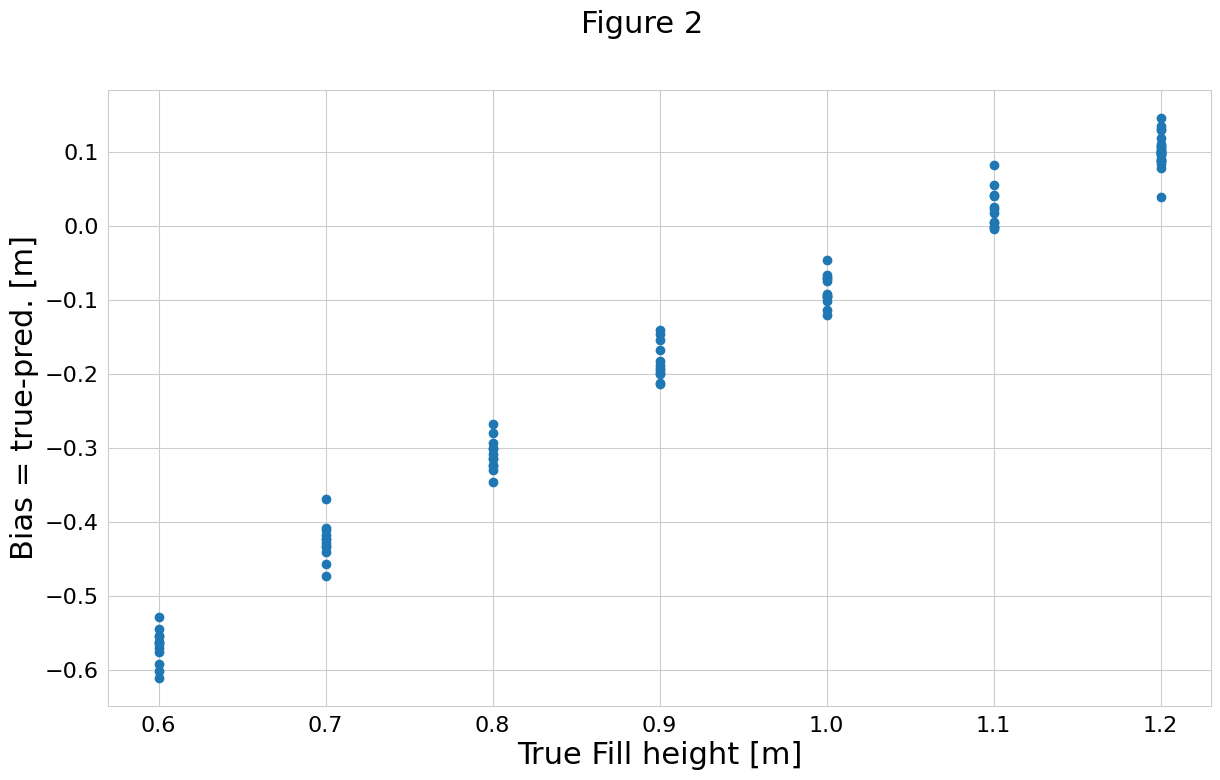

In [91]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 2", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.bias)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('Bias = true-pred. [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)

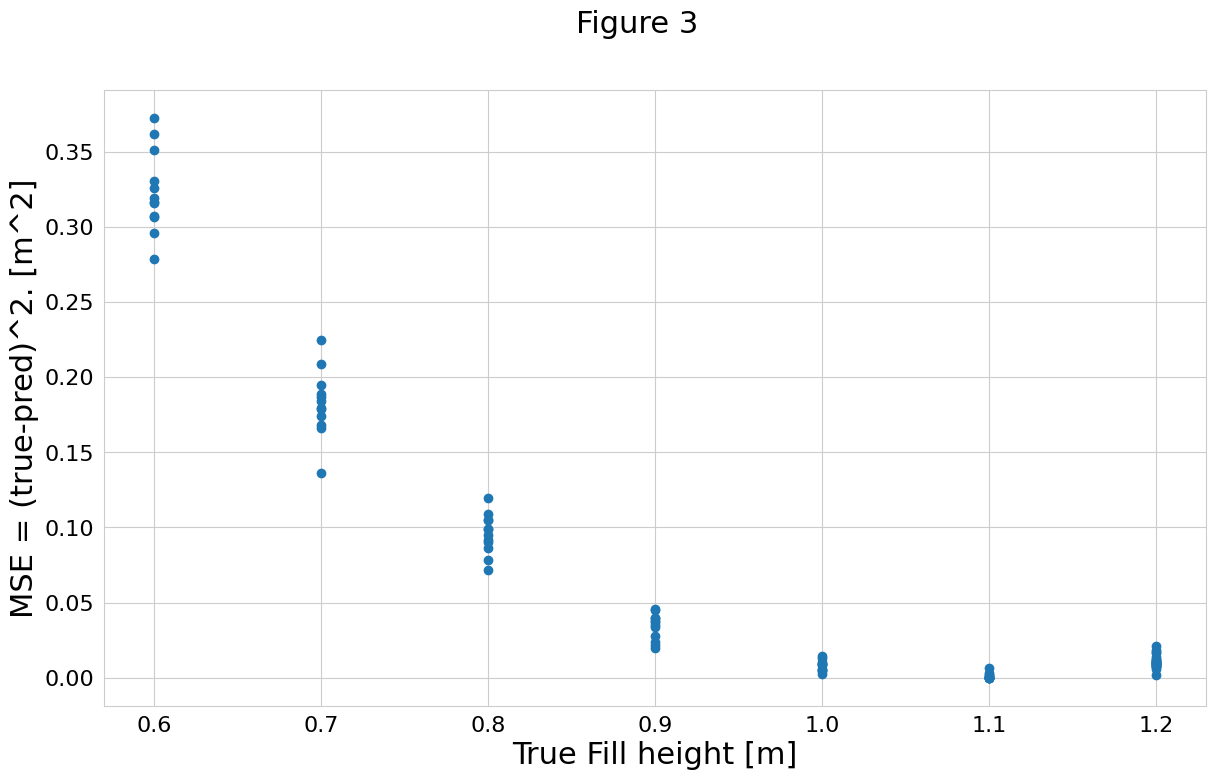

In [92]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 3", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.mse)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('MSE = (true-pred)^2. [m^2]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)